In [1]:
import time
import os

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import pytorch_lightning as pl

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from cancernet.arch import InteractionNet, VisibleGraphInteractionNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [3]:
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [4]:
maps[0].sum(axis=0).sort_values(ascending=False).head(20)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
R-HSA-199991     382.0
R-HSA-556833     366.0
R-HSA-1280215    339.0
R-HSA-422475     285.0
R-HSA-9006934    268.0
R-HSA-5663202    245.0
R-HSA-194315     218.0
R-HSA-5663205    206.0
R-HSA-2262752    186.0
R-HSA-9006925    180.0
R-HSA-5683057    168.0
R-HSA-71291      165.0
R-HSA-195721     165.0
R-HSA-72203      163.0
R-HSA-71387      161.0
dtype: float64

In [5]:
# use only top subsys
#n_top = 12
#maps[0] = maps[0][maps[0].sum(axis=0).sort_values(ascending=False).head(n_top).index]
maps[0].head()

,R-HSA-109581,R-HSA-112307,R-HSA-112315,R-HSA-1181150,R-HSA-1187000,R-HSA-1268020,R-HSA-1280215,R-HSA-1280218,R-HSA-1296071,R-HSA-1362409,...,R-HSA-9006927,R-HSA-9006931,R-HSA-9006934,R-HSA-9006936,R-HSA-9033241,R-HSA-917937,R-HSA-927802,R-HSA-977225,R-HSA-983231,R-HSA-983712
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADACL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
maps[0].shape

(9054, 146)

## Train

Set up hyperparameters and random seed.

In [7]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.001

Global seed set to 42


Prepare data.

In [8]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Create and train model.

In [9]:
# input node feature size
inputs = 3
# output dimensions of each subgraph
outputs = 1
# size of hidden layers in graphs (both MLP size and latent representation of nodes and edge)
hidden = 16
# number of graphs to stack
layers = 2

t0 = time.time()
model = VisibleGraphInteractionNet(
    pathway_maps=maps,
    node_index=dataset.node_index,
    # edge_model=edge_model, node_model=node_model, global_model=global_model,
    model_config={
        "inputs": inputs,
        "outputs": outputs,
        "hidden": hidden,
        "layers": layers,
    },
    sparse=False,
    lr=lr,
)
logger = InMemoryLogger()

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar()],
    logger=logger,
    # deterministic=True,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | subsys | ModuleList | 880 K 
1 | nn     | Sequential | 3.9 K 
--------------------------------------
884 K     Trainable params
0         Non-trainable params
884 K     Total params
3.539     Total estimated model params size (MB)
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytor

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training took 7229.0 seconds.


Visualize training trajectory.

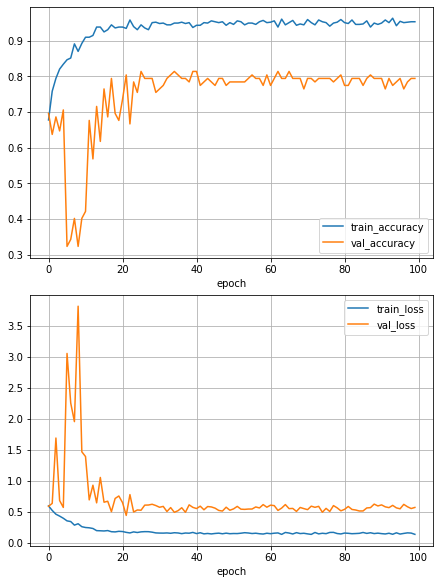

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

Calculate and show ROC and AUC.

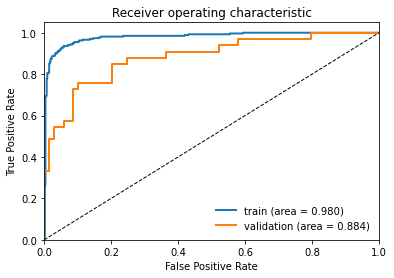

In [11]:
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [12]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=True,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.83
auc 0.85119855269109
aupr 0.7463898728336988
f1 0.7536231884057971
precision 0.7222222222222222
recall 0.7878787878787878
